Source code: https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html

- [What is anchor box?](https://medium.com/@andersasac/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9)
- [Research paper: SSD - Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)

# OBJECT DETECTION USING CNN
# SSD: Single Shot MultiBox Detector
Let’s start by explaining where the name of this architecture comes from:
- Single Shot: this means that the tasks of object localization and classification are done in a single forward pass of the network
- MultiBox: this is the name of a technique for bounding box regression developed by Szegedy et al.
- Detector: The network is an object detector that also classifies those detected objects

The SSD model predicts anchor boxes at multiple scales. The model architecture is illustrated in the following figure.
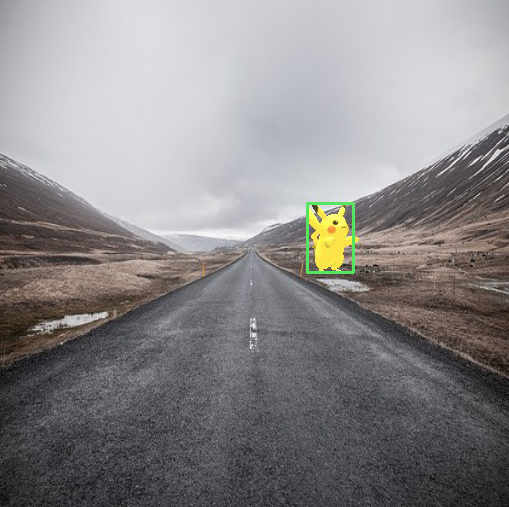

We first use a body network to extract the image features, which are used as the input to the first scale (scale 0). The class labels and the corresponding anchor boxes are predicted by class_predictor and box_predictor, respectively. We then downsample the representations to the next scale (scale 1). Again, at this new resolution, we predict both classes and anchor boxes. This downsampling and predicting routine can be repeated in multiple times to obtain results on multiple resolution scales. Let’s walk through the components one by one in a bit more detail.

### Default anchor boxes
Since an anchor box can have arbituary shape, we sample a set of anchor boxes as the candidate. In particular, for each pixel, we sample multiple boxes centered at this pixel but have various sizes and ratios. Assume the input size is $w×h$, - for size $s∈(0,1]$, the generated box shape will be $ws×hs$ - for ratio $r>0$, the generated box shape will be $w\sqrt{r} \times \frac{h}{\sqrt{r}}$

We can sample the boxes using the operator MultiBoxPrior. It accepts n sizes and m ratios to generate $n+m-1$ boxes for each pixel. The first i boxes are generated from sizes[i], ratios[0] if $i≤n$ otherwise sizes[0], ratios[i-n].

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

# MultiBoxPrior: Generate prior(anchor) boxes from data, sizes and ratios.
# https://beta.mxnet.io/api/ndarray/_autogen/mxnet.ndarray.contrib.MultiBoxPrior.html
y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))

print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>


We can visualize all anchor boxes generated for one pixel on a certain size feature map.

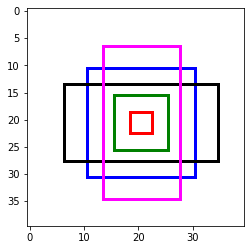

In [44]:
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), 
                         (box[2]-box[0]), 
                         (box[3]-box[1]), 
                         fill=False, edgecolor=color, linewidth=linewidth)

colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]

for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
    
plt.show()

### Predict classes
For each anchor box, we want to predict the associated class label. We make this prediction by using a convolution layer. We choose a kernel of size 3×3 with padding size (1,1) so that the output will have the same width and height as the input. The confidence scores for the anchor box class labels are stored in channels. In particular, for the i-th anchor box:

- channel i*(num_class+1) store the scores for this box contains only background
- channel i*(num_class+1)+1+j store the scores for this box contains an object from the j-th class

In [45]:
from mxnet.gluon import nn

def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 55, 20, 20)


### Predict anchor boxes
The goal is predict how to transfer the current anchor box to the correct box. That is, assume b is one of the sampled default box, while Y is the ground truth, then we want to predict the delta positions $\Delta(Y, b)$, which is a 4-length vector.

More specifically, the we define the delta vector as: $[t_x, t_y, t_{width}, t_{height}]$, where

- $t_x = (Y_x - b_x) / b_{width}$
- $t_y = (Y_y - b_y) / b_{height}$
- $t_{width} = (Y_{width} - b_{width}) / b_{width}$
- $t_{height} = (Y_{height} - b_{height}) / b_{height}$

Normalizing the deltas with box width/height tends to result in better convergence behavior.

Similar to classes, we use a convolution layer here. The only difference is that the output channel size is now num_anchors * 4, with the predicted delta positions for the i-th box stored from channel $i*4$ to $i*4+3$.

In [46]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


### Down-sample features
Each time, we downsample the features by half. This can be achieved by a simple pooling layer with pooling size 2. We may also stack two convolution, batch normalization and ReLU blocks before the pooling layer to make the network deeper.

In [47]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


### Manage preditions from multiple layers
A key property of SSD is that predictions are made at multiple layers with shrinking spatial size. Thus, we have to handle predictions from multiple feature layers. One idea is to concatenate them along convolutional channels, with each one predicting a corresponding value (class or box) for each default anchor. We give class predictor as an example, and box predictor follows the same rule.

In [48]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)

# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [49]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


### Body network
The body network is used to extract features from the raw pixel inputs. Common choices follow the architectures of the state-of-the-art convolution neural networks for image classification. For demonstration purpose, we just stack several down sampling blocks to form the body network.

In [50]:
from mxnet import gluon

def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


### Create a toy SSD model
Now, let’s create a toy SSD model that takes images of resolution 256×256 as input.

In [51]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global

### Forward
Given an input and the model, we can run the forward pass.

In [52]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

### Put all things together

In [53]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

### Outputs of ToySSD

In [54]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 3) box prediction (1, 21776)


### Dataset
For demonstration purposes, we’ll train our model to detect Pikachu in the wild. We generated a synthetic toy dataset by rendering images from open-sourced 3D Pikachu models. The dataset consists of 1000 pikachus with random pose/scale/position in random background images. The exact locations are recorded as ground-truth for training and validation.

### Download dataset

In [55]:
from mxnet.test_utils import download
import os.path as osp

def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

for k, v in hashes.items():
    fname = 'pikachu_' + k
    target = osp.join('data', fname)
    url = url_format.format(k)
    if not osp.exists(target) or not verified(target, v):
        print('Downloading', target, url)
        download(url, fname=fname, dirname='data', overwrite=True)

### Load dataset

In [56]:
import mxnet.image as image
data_shape = 256
batch_size = 32
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_train.rec',
        path_imgidx='./data/pikachu_train.idx',
        shuffle=True, mean=True, rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


### Illustration
Let’s display one image loaded by ImageDetIter.

[0.         0.26507762 0.2430489  0.42811823 0.48279044]


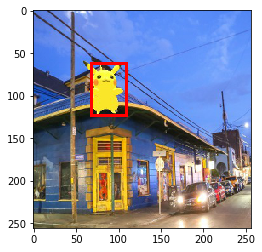

In [57]:
import numpy as np

img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)

# draw bounding boxes on image
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
    
plt.imshow(img)
plt.show()

### Train
#### Losses
Network predictions will be penalized for incorrect class predictions and wrong box deltas.

In [58]:
from mxnet.contrib.ndarray import MultiBoxTarget

def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

Pre-defined losses are provided in gluon.loss package, however, we can define losses manually.

First, we need a Focal Loss for class predictions.

In [59]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


Next, we need a SmoothL1Loss for box predictions.

In [60]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


#### Evaluation metrics
Here, we define two metrics that we’ll use to evaluate our performance whien training. You’re already familiar with accuracy unless you’ve been naughty and skipped straight to object detection. We use the accuracy metric to assess the quality of the class predictions. Mean absolute error (MAE) is just the L1 distance, introduced in our linear algebra chapter. We use this to determine how close the coordinates of the predicted bounding boxes are to the ground-truth coordinates. Because we are jointly solving both a classification problem and a regression problem, we need an appropriate metric for each task.

In [61]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

No GPU enabled, fall back to CPU, sit back and be patient...


#### Initialize parameters

In [62]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

#### Set up trainer

In [63]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

#### Start training
Optionally we load pretrained model for demonstration purpose. One can set from_scratch = True to training from scratch, which may take more than 30 mins to finish using a single capable GPU.

In [77]:
epochs = 5  # set larger to get better performance
log_interval = 20
from_scratch = False  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 148
    pretrained = 'ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not osp.exists(pretrained) or not verified(pretrained, sha1):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_parameters(pretrained, ctx)

In [78]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# we can save the trained parameters to disk
net.save_parameters('ssd_%d.params' % epochs)

### Test
Testing is similar to training, except that we don’t need to compute gradients and training targets. Instead, we take the predictions from network output, and combine them to get the real detection output.

#### Prepare the test data

In [79]:
import numpy as np
import cv2

def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

image = cv2.imread('./data/pikachu-2.jpg')
x = preprocess(image)
print('x', x.shape)

x (1, 3, 256, 256)


#### Network inference
In a single line of code!

In [80]:
# if pre-trained model is provided, we can load it
# net.load_parameters('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.151625    0.151625  ]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ...
  [ 0.01949999  0.01949999  0.9805      0.9805    ]
  [-0.12225395  0.18887302  1.1222539   0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.1222539 ]]]
<NDArray 1x5444x4 @cpu(0)>
class predictions 
[[[ 0.6662506  -1.5115829 ]
  [ 1.0917249  -1.5090508 ]
  [ 0.8360464  -1.3183345 ]
  ...
  [-0.38675523 -1.572966  ]
  [ 0.30136618 -0.9118096 ]
  [ 0.36957535 -0.8522036 ]]]
<NDArray 1x5444x2 @cpu(0)>
box delta predictions 
[[ 0.33740264 -0.28051823 -0.30605808 ... -0.08541534 -0.16156091
  -0.13800786]]
<NDArray 1x21776 @cpu(0)>


#### Convert predictions to real object detection results

In [81]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 0.          0.30993494  0.5744303   0.5260701   0.70126504
    0.7305453 ]
  [ 0.          0.2811837   0.08944124 -0.02093089  1.0605533
    1.0030359 ]
  [ 0.          0.2802707   0.27745956  0.6095739   0.39927495
    0.8216695 ]
  ...
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]]]
<NDArray 1x5444x6 @cpu(0)>


Each row in the output corresponds to a detection box, as in format [class_id, confidence, xmin, ymin, xmax, ymax].

Most of the detection results are -1, indicating that they either have very small confidence scores, or been suppressed through non-maximum-suppression.

#### Display results

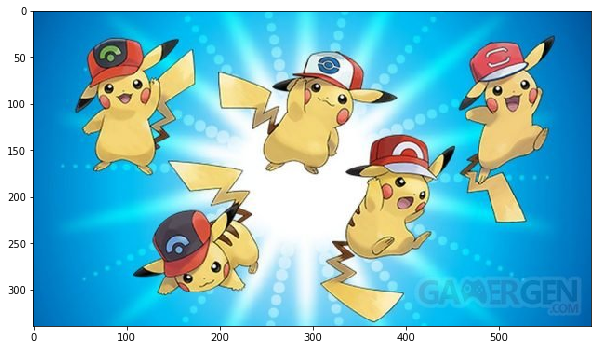

In [82]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, 
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.45)

### Conclusion
Detection is harder than classification, since we want not only class probabilities, but also localizations of different objects including potential small objects. Using sliding window together with a good classifier might be an option, however, we have shown that with a properly designed convolutional neural network, we can do single shot detection which is blazing fast and accurate!